In [1]:
import pandas as pd
import numpy as np
import ast, gc
import re, math

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = '/Users/irenaradzevich/Documents/sergei_dev/final project/'

In [4]:
data = pd.read_csv(PATH+'data.csv')

In [5]:
data.shape

(377185, 18)

In [6]:
data = data[~pd.isna(data.target)]      # drop records without target's value

In [7]:
data.columns = [i.replace('.','_') for i in data.columns]
data.columns = [i.replace(' ','_') for i in data.columns]
data.columns = [i.replace('-','_') for i in data.columns]

In [8]:
data.homeFacts = data.homeFacts.apply(lambda x: ast.literal_eval(x))
data.schools = data.schools.apply(lambda x: ast.literal_eval(x))

In [9]:
data.sample(10).T

,86744,119097,136211,248563,200742,156361,50189,89676,96391,354884
status,For sale,for sale,NaN,For sale,for sale,Active,foreclosure,Active,for sale,Active
private_pool,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
propertyType,Single Family,single-family home,Single Family,Single Family,single-family home,NaN,single-family home,Single Family Home,single-family home,NaN
street,233 E 17th St,8944 S Oakley Ave,2602 W 64th St,1944 Capitol Ave NE # 3,714 Hollybrook Dr,128 Birchwood Ln,248 Mary Dr,57 Redwood Ct,2304 Pinehurst St,23106 Casey Cyn
baths,Bathrooms: 2,NaN,2.0,3.0,2 Baths,NaN,2 Baths,2,5 Baths,"2,250"
homeFacts,"{'atAGlanceFacts': [{'factValue': '1913', 'fac...","{'atAGlanceFacts': [{'factValue': '1933', 'fac...","{'atAGlanceFacts': [{'factValue': '1989', 'fac...","{'atAGlanceFacts': [{'factValue': '1943', 'fac...","{'atAGlanceFacts': [{'factValue': '2004', 'fac...","{'atAGlanceFacts': [{'factValue': '', 'factLab...","{'atAGlanceFacts': [{'factValue': '1972', 'fac...","{'atAGlanceFacts': [{'factValue': '2020', 'fac...","{'atAGlanceFacts': [{'factValue': '2006', 'fac...","{'atAGlanceFacts': [{'factValue': '', 'factLab..."
fireplace,NaN,yes,NaN,NaN,yes,NaN,yes,NaN,yes,NaN
city,Jacksonville,Chicago,Hialeah,Washington,Longview,Mocksville,Binghamton,Poinciana,Tyler,San Antonio
schools,"[{'rating': ['2/10', '3/10', '3/10'], 'data': ...","[{'rating': ['7/10', '4/10', '1/10'], 'data': ...","[{'rating': ['7/10', '4/10'], 'data': {'Distan...","[{'rating': ['3/10', '3/10'], 'data': {'Distan...","[{'rating': ['5/10', '4/10', '4/10'], 'data': ...","[{'rating': ['6', '4', '4'], 'data': {'Distanc...","[{'rating': ['5/10', '7/10', '6/10'], 'data': ...","[{'rating': ['2', '1', '3', '3', '6', 'NR'], '...","[{'rating': ['6/10', '6/10', '7/10'], 'data': ...","[{'rating': ['10', '6', '7'], 'data': {'Distan..."
sqft,"Total interior livable area: 1,368 sqft","1,454 sqft","1,170 sqft","1,185","1,889 sqft",NaN,"2,001 sqft",1888,"5,641 sqft","2,807,917"


In [10]:
def find_number(field: str):
    """
    function to take only first numeric data from string
    :param field: string to find number
    :return: number (in string format)
    """

    # mask for search
    p = '[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+'

    # main cycle for searching
    if re.search(p, field) is not None:
        for catch in re.finditer(p, field):
            res = catch[0]
            if re.search(',', res) is not None:
                res = res.replace(',', '')
            return res

    else: return 0

In [11]:
data.target = data.target.apply(find_number).apply(int)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335447 non-null  object
 1   private_pool  4151 non-null    object
 2   propertyType  340150 non-null  object
 3   street        374702 non-null  object
 4   baths         269328 non-null  object
 5   homeFacts     374704 non-null  object
 6   fireplace     102522 non-null  object
 7   city          374670 non-null  object
 8   schools       374704 non-null  object
 9   sqft          334582 non-null  object
 10  zipcode       374704 non-null  object
 11  beds          283748 non-null  object
 12  state         374704 non-null  object
 13  stories       224910 non-null  object
 14  mls_id        24937 non-null   object
 15  PrivatePool   40121 non-null   object
 16  MlsId         310226 non-null  object
 17  target        374704 non-null  int64 
dtypes: int64(1), object(17)


In [13]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import warnings
from sklearn import metrics
from sklearn.manifold import TSNE   # t-SNE – algorithm to downsize of matrix

from catboost import CatBoostRegressor
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
import category_encoders as ce
from tqdm.notebook import tqdm

In [14]:
def mape(y_true, y_pred):
    """
    function to calculate Mean Absolute Percentage Error
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))*100

def smape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true))/(y_true+y_pred))*100

In [15]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred-y_true))*100

In [16]:
def mpl(alpha=0.5):
    """
    mean pinball loss
    :param y_true:
    :param y_pred:
    :param alpha:
    :return:
    """
    test_up = results.y_test > results.predict
    predict_up = results.y_test < results.predict
    a = results[test_up]['y_test'].sum() - results[test_up]['predict'].sum()
    b = results[predict_up]['predict'].sum() - results[predict_up]['y_test'].sum()
    mpl_value =  (alpha * a + (1 - alpha) * b) / results.shape[0]

    count_test_up = results[test_up]['y_test'].count() / results.shape[0]

    avg_under_test = a / results[test_up]['y_test'].count()
    avg_upper_test = b / results[predict_up]['y_test'].count()

    return mpl_value, 1-count_test_up, avg_under_test, avg_upper_test

In [17]:
results = pd.DataFrame()
def feature_imp(dataset, regressor, encoder, test_drop = True, target='price'):
    """
    function for checking feature importance on ML
    :param dataset: dataset for ML
    :param regressor: algorithm of ML
    :param encoder: encoder for categorical vectors
    :param test_drop: boolean flag whether need to separate test data from dataset
    :param target: name of target
    :return: list of features with weights descending, score of algorithm and MAPE score
    """
    global results

    # copy dataset useful if you need to drop some vectors from dataset
    dataset=dataset.copy()

    # checkin boolean flag to drop test data from dataset
    if test_drop:
        dataset = dataset[dataset.test == 0]

    # drop vector 'test'
    # dataset.drop(['test'], axis=1, inplace=True)

    # make variables x and y for ML model
    x, y = dataset.drop(target, axis=1), np.log(dataset[target])

    # encoding categorical vectors with encoder
    encoder.fit(x, y)
    X = encoder.transform(x)

    # split for validate and fit ML model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
    regressor.fit(X_train, y_train)

    # make dataframe with features importance
    importance = regressor.feature_importances_
    value = pd.DataFrame(data=importance, index=X.columns, columns=['importance'])
    print(value.importance.sort_values(ascending=False))

    # calculate ML model score
    score = regressor.score(X_test, y_test)

    y_true = np.exp(y_test)
    predict = np.exp(regressor.predict(X_test))

    if not results.empty:
        results.drop(columns=results.columns, inplace=True)
    results = X_test.copy()
    results['y_test'] = np.exp(y_test)
    results['predict'] = predict.astype('int64')

    # calculate metrics
    print(f'Score of regressor {score*100:0.2f}%')
    print(f"MAPE: {(mape(y_true, predict)):0.2f}%, SMAPE: {(smape(y_true, predict)):0.2f}%")
    print(f"MAE: {math.trunc(mae(y_true, predict))}$, ")
    mpl_value, p, avg_under_test, avg_upper_test = mpl(alpha=0.01)
    print(f"Pinball Loss: {(mpl_value):0.2f}, over_pricing: {p:0.2f}%, mean over pricing: {avg_upper_test:0.0f}")
    print(f"                   under_pricing: {(1-p):0.2f}%, mean under pricing: {avg_under_test:0.0f}")

In [20]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                #'status_sale', 'status_foreclosure', 'status_cancel',
                #'status_lem'
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target = TARGET, **parameters)

Learning rate set to 0.107713
0:	learn: 1.1315313	total: 95.6ms	remaining: 1m 35s
1:	learn: 1.0637674	total: 120ms	remaining: 59.6s
2:	learn: 1.0045170	total: 143ms	remaining: 47.6s
3:	learn: 0.9523561	total: 172ms	remaining: 43s
4:	learn: 0.9077034	total: 209ms	remaining: 41.6s
5:	learn: 0.8676011	total: 238ms	remaining: 39.5s
6:	learn: 0.8324208	total: 270ms	remaining: 38.3s
7:	learn: 0.8013528	total: 363ms	remaining: 45s
8:	learn: 0.7745704	total: 444ms	remaining: 48.9s
9:	learn: 0.7507779	total: 533ms	remaining: 52.7s
10:	learn: 0.7302539	total: 597ms	remaining: 53.7s
11:	learn: 0.7118471	total: 622ms	remaining: 51.2s
12:	learn: 0.6962344	total: 650ms	remaining: 49.4s
13:	learn: 0.6820393	total: 681ms	remaining: 48s
14:	learn: 0.6696226	total: 703ms	remaining: 46.2s
15:	learn: 0.6584209	total: 737ms	remaining: 45.3s
16:	learn: 0.6486683	total: 773ms	remaining: 44.7s
17:	learn: 0.6396797	total: 819ms	remaining: 44.7s
18:	learn: 0.6316699	total: 855ms	remaining: 44.2s
19:	learn: 0.62

In [ ]:
# accuracy = 86.93, MAPE 299.39%, SMAPE 11.52%, MAE 18_675_602, PL 58150,  op 113228, up 262439  -  naive
# accuracy = 85.00, MAPE 383.13%, SMAPE 11.76%, MAE 17_798_542, PL 57366,  op 113937, up 261892  -  drop status
#### accuracy = 86.81, MAPE 319.26%, SMAPE 11.55%, MAE 18_733_201, PL 58840,  op 114735, up 261892  -  status dumm

In [109]:
results

,status,private_pool,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls_id,PrivatePool,MlsId,y_test,predict
217030,12.663277,12.636953,12.706803,14.865062,14.652063,12.950600,13.945941,14.083398,14.731618,13.646416,13.524716,12.898182,12.639618,13.163202,14.865062,6475000.0,5744757
227279,12.583558,12.636953,12.588807,12.640429,12.207072,12.515784,12.915166,12.464433,12.860876,12.211277,13.029953,12.480323,12.639618,12.570114,12.014112,160000.0,164812
99107,12.663277,12.636953,12.706803,12.106189,12.459408,12.515784,12.507752,12.087611,12.233388,12.509218,12.457850,12.508463,12.639618,12.570114,12.106189,147500.0,156568
252844,12.663277,12.636953,12.706803,12.640429,12.953336,12.515784,12.434255,12.805962,12.578200,12.548750,12.457850,12.508463,12.639618,12.570114,12.640429,264000.0,345687
248606,12.663277,12.636953,12.971014,12.640429,12.459408,12.515784,12.927429,12.123504,13.226131,12.509218,12.457850,12.480323,12.639618,12.570114,12.640429,384900.0,384137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21762,12.663277,12.636953,11.432210,12.619308,12.207072,12.515784,12.548953,12.610286,12.541534,12.548750,11.848436,12.480323,12.639618,12.570114,12.640429,300000.0,214120
301532,12.663277,12.636953,12.706803,12.640429,13.426701,12.950600,11.830958,13.173750,11.394903,12.916803,12.497557,12.480323,12.639618,12.570114,12.640429,375000.0,322633
200308,12.748691,12.636953,12.825482,12.640429,13.047302,12.262872,12.384489,12.934443,12.133492,13.068622,12.596095,12.851075,12.639618,12.570114,12.640429,242381.0,239588
236235,12.845170,12.636953,12.825482,12.640429,12.331893,12.515784,11.949004,12.736067,12.172791,12.842293,12.035290,12.851075,12.640429,12.570114,12.629566,249900.0,185976


In [18]:
print(f' min: {data.target.min()}, max: {data.target.max()}, ')
print(f' median: {data.target.median():0.0f}, avg: {data.target.mean():0.0f}')

 min: 1, max: 195000000, 
 median: 320000, avg: 644725


<AxesSubplot:xlabel='target', ylabel='Count'>

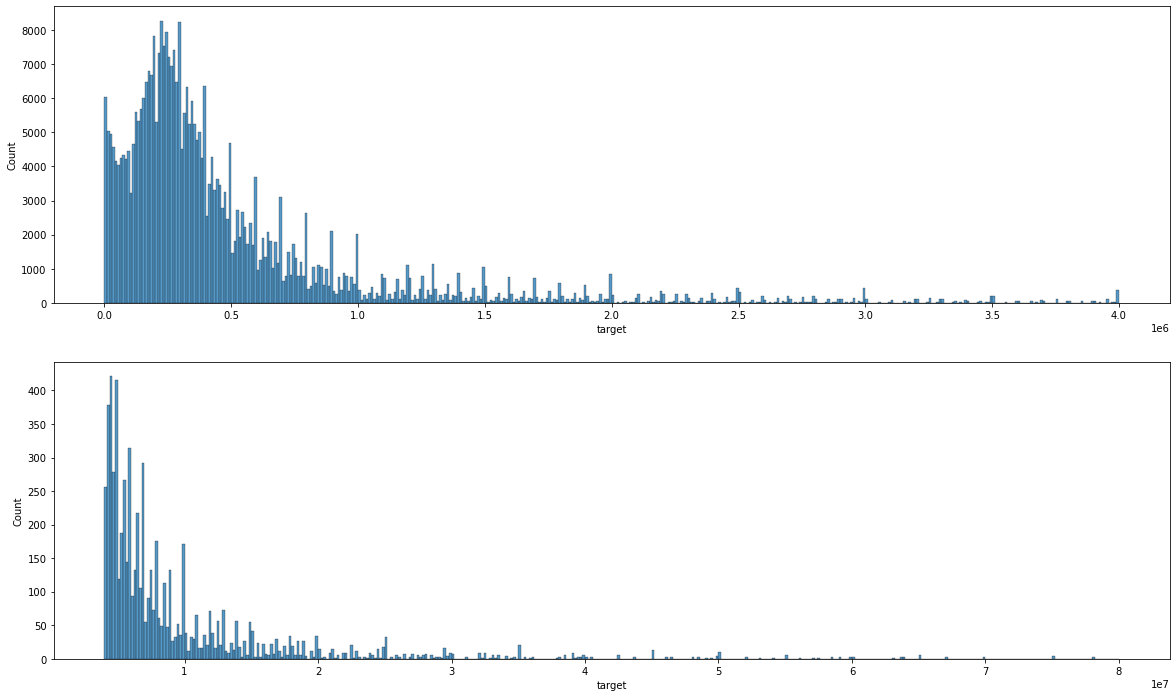

In [19]:
fig, ax = plt.subplots(figsize = (20, 12))
plt.subplot(211)
sns.histplot(data.target, binwidth=10000, binrange=(0,4000000))
plt.subplot(212)
sns.histplot(data.target, binwidth=200000, binrange=(4000000,80000000))

# Исследование целевой переменной

* Цена имеет очень широкий диапазон значений от 1 до 195 млн.долларов. Несмотря на такой разброс - это не "качество", а его отсутствие. надо понимать, что цены на дома или недвижимость в целом в Америке (да и где бы то ни было) не могут иметь цену в 1, 10, 100, 1000 или даже 10 000 долларов. Есть подозрение, что цены менее 50 000 - подозрительны. Так что, предметом дальнейшего исследования целевой переменной будет оценка нижней границы отсеивания данных. В конечную модель эти данные подавать нельзя. Смысл таких цифр в графе "цена" - это просто заполнить его, как "обязательное" по условиям формы. А реальная цена собственником будет оперделятся при других обстоятельствах. Но эти обстоятельства нами не могут быть дифференцируемы.
* График демонстрирует условную "гладкость" распределения значений цены. Однако, надо учитывать специфику предмета "цена недвижимости". Несмотря на кажущийся огромным массив записей, несмотря на то, что некоторые значения формируются по строгой формуле *(цена)* * *(площадь)*, все равно, конечная цена будет сформирована субъективно. Мы и сейчас на графике наблюдаем пики прямо у "круглых" значений цены. Таким образом, учитывая, что это не массив данных о конечных сделках, а заявления продавцов о своих желаниях, вполне уместно было бы округлить цены до ближайших значений кратных десятичной степени в большую сторону. Вопрос стоит только в определении разряда округления. Скорее всего нужно рассмотреть схему окургления до "n-3 разряда".
* Учитывая широкий диапазон значений, понятно, что избежать логарифмирования целевой переменной в процессе применения ML или DL моделей не удастся.
* В базе данных менее 0.5% записей с объектами цной более 10 млн.долларов. По всему видно, что это эксклюзивные предложения, которых вообще не так много. Соответственно и цены на них сформированы не сходя из стандартного списка параметров. Стоит рассмотреть механизм моделирования таких вариантов отдельно.
* В итоге работы следует определиться с практическим применением результатов работы модели. Вариантом такого применения может быть поиск предложений, цена на которые была бы ниже предсказанной. При этом у модели нужно предусмотреть настройку, чтобы ошибка "вверх", то есть, переоценка цены была бы мнимальная, а чаще имело место недооценка.

In [20]:
def round_price(price):
    return np.around(price, -(len(str(price))-3))

n = [15670, 870998, 3298701, 22760983, 616143005]

for item in range(len(n)):
    print(n[item],' -> ', round_price(n[item]))

15670  ->  15700
870998  ->  871000
3298701  ->  3300000
22760983  ->  22800000
616143005  ->  616000000


## Vector 'status'

In [21]:
data.status.fillna('nan', inplace=True)
data.status = data.status.apply(str.lower)

#filter records with realty for rent
rent = data[data.status.str.contains('rent')]
data = data[~data.status.str.contains('rent')]

In [22]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target = TARGET, **parameters)

Learning rate set to 0.107692
0:	learn: 1.1187752	total: 35.9ms	remaining: 35.9s
1:	learn: 1.0506839	total: 66.8ms	remaining: 33.3s
2:	learn: 0.9909427	total: 95ms	remaining: 31.6s
3:	learn: 0.9377338	total: 125ms	remaining: 31.1s
4:	learn: 0.8917423	total: 155ms	remaining: 30.8s
5:	learn: 0.8524646	total: 190ms	remaining: 31.5s
6:	learn: 0.8178205	total: 231ms	remaining: 32.7s
7:	learn: 0.7870974	total: 262ms	remaining: 32.5s
8:	learn: 0.7597343	total: 292ms	remaining: 32.2s
9:	learn: 0.7354594	total: 323ms	remaining: 32s
10:	learn: 0.7138366	total: 357ms	remaining: 32.1s
11:	learn: 0.6954817	total: 378ms	remaining: 31.1s
12:	learn: 0.6790885	total: 403ms	remaining: 30.6s
13:	learn: 0.6640397	total: 431ms	remaining: 30.4s
14:	learn: 0.6506230	total: 463ms	remaining: 30.4s
15:	learn: 0.6388824	total: 514ms	remaining: 31.6s
16:	learn: 0.6282474	total: 551ms	remaining: 31.9s
17:	learn: 0.6189711	total: 574ms	remaining: 31.3s
18:	learn: 0.6106237	total: 593ms	remaining: 30.6s
19:	learn: 0

In [ ]:
# accuracy = 86.93, MAPE 299.39%, SMAPE 11.52%, MAE 18_675_602, PL 58150,  op 113228, up 262439  -  naive
# accuracy = 85.00, MAPE 383.13%, SMAPE 11.76%, MAE 17_798_542, PL 57366,  op 113937, up 261892  -  drop status
# accuracy = 86.72, MAPE 338.46%, SMAPE 11.61%, MAE 18_777_345, PL 58477,  op 114306, up 262806  -  drop rent

<AxesSubplot:xlabel='target', ylabel='Count'>

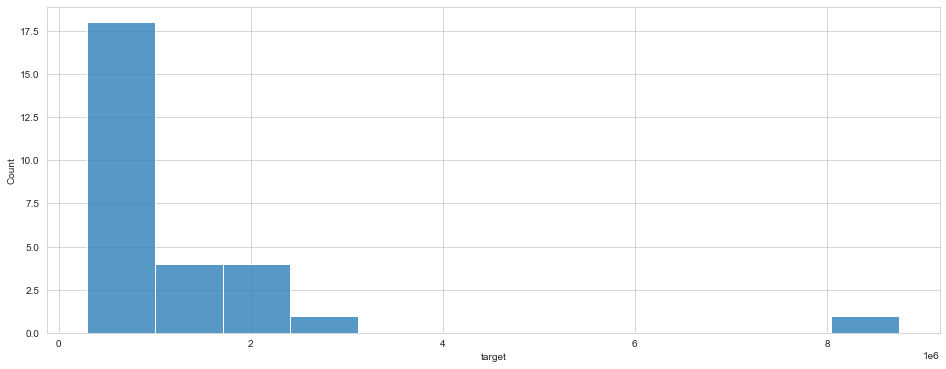

In [168]:
x = data[data.status.str.contains('listing extended')]
fig, ax = plt.subplots(figsize = (16, 6))
sns.histplot(x.target)

In [169]:
x.target.min(), x.target.max()

(298900, 8750000)

In [22]:
# sale as it is
sale = ['sale', 'active',
        'pending',                  # pending - status waiting of payments or documents
        'under', 'contract',        # under contract - status waiting of payments
        'nan',
        'listing extended'          # technical status to extend period of offer
        ]

# sale with discount
foreclosure = ['foreclos',          # foreclosure - usually sale with discount 33%
               'auction',
               'conting'            # contingent - usually has some difficult
               ]

# cancel of sale
cancels = ['due diligence'          #
           ]

In [23]:
def status_dummy(field, control_list):

#    print(control_list)
    for item in control_list:
        if field.find(item) > -1:
            return 1
    return 0

In [24]:
data['status_sale'] = data.status.apply(lambda q: status_dummy(q, sale))
data['status_foreclosure'] = data.status.apply(lambda q: status_dummy(q, foreclosure))
data['status_cancel'] = data.status.apply(lambda q: status_dummy(q, cancels))

In [26]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.107692
0:	learn: 1.1185019	total: 28.7ms	remaining: 28.7s
1:	learn: 1.0503978	total: 54.6ms	remaining: 27.2s
2:	learn: 0.9907360	total: 76.3ms	remaining: 25.3s
3:	learn: 0.9383554	total: 103ms	remaining: 25.7s
4:	learn: 0.8913815	total: 124ms	remaining: 24.6s
5:	learn: 0.8506016	total: 150ms	remaining: 24.9s
6:	learn: 0.8151431	total: 175ms	remaining: 24.8s
7:	learn: 0.7837768	total: 210ms	remaining: 26s
8:	learn: 0.7566392	total: 250ms	remaining: 27.5s
9:	learn: 0.7326229	total: 297ms	remaining: 29.4s
10:	learn: 0.7104023	total: 347ms	remaining: 31.2s
11:	learn: 0.6915656	total: 392ms	remaining: 32.3s
12:	learn: 0.6749453	total: 416ms	remaining: 31.6s
13:	learn: 0.6594041	total: 445ms	remaining: 31.3s
14:	learn: 0.6458884	total: 477ms	remaining: 31.3s
15:	learn: 0.6344075	total: 501ms	remaining: 30.8s
16:	learn: 0.6239021	total: 535ms	remaining: 30.9s
17:	learn: 0.6147838	total: 556ms	remaining: 30.4s
18:	learn: 0.6062059	total: 578ms	remaining: 29.8s
19:	learn:

In [ ]:
# accuracy = 86.93, MAPE 299.39%, SMAPE 11.52%, MAE 18_675_602, PL 58150,  op 113228, up 262439  -  naive
# accuracy = 85.00, MAPE 383.13%, SMAPE 11.76%, MAE 17_798_542, PL 57366,  op 113937, up 261892  -  drop status
# accuracy = 86.72, MAPE 338.46%, SMAPE 11.61%, MAE 18_777_345, PL 58477,  op 114306, up 262806  -  drop rent
# accuracy = 86.81, MAPE 319.26%, SMAPE 11.55%, MAE 18_733_201, PL 58840,  op 114735, up 261892  -  status dummy

## Vector 'private_pool'

In [25]:
pp = data.loc[:,['private_pool', 'PrivatePool']]
pp.fillna('na', inplace=True)
pp['compare'] = data.apply(lambda q: q.private_pool == q.PrivatePool, axis=1)

In [26]:
pp.groupby(['private_pool', 'PrivatePool'])['compare'].count()

private_pool  PrivatePool
Yes           na               4151
na            Yes             11432
              na             330117
              yes             28592
Name: compare, dtype: int64

In [27]:
pp_replace={'yes':1, 'na':0}

In [28]:
pp.private_pool = pp.private_pool.apply(str.lower).map(pp_replace)
pp.PrivatePool = pp.PrivatePool.apply(str.lower).map(pp_replace)
pp.groupby(['private_pool', 'PrivatePool'])['compare'].count()

private_pool  PrivatePool
0             0              330117
              1               40024
1             0                4151
Name: compare, dtype: int64

In [29]:
pp['pool'] = pp.private_pool + pp.PrivatePool
pp.groupby(['pool', 'private_pool', 'PrivatePool'])['compare'].count()

pool  private_pool  PrivatePool
0     0             0              330117
1     0             1               40024
      1             0                4151
Name: compare, dtype: int64

In [30]:
data.private_pool = pp.pool
data.drop('PrivatePool', inplace=True, axis=1)
del pp
gc.collect()

1220

In [33]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.107692
0:	learn: 1.1185358	total: 29.8ms	remaining: 29.7s
1:	learn: 1.0498676	total: 54.9ms	remaining: 27.4s
2:	learn: 0.9903212	total: 79ms	remaining: 26.2s
3:	learn: 0.9382917	total: 102ms	remaining: 25.3s
4:	learn: 0.8920758	total: 123ms	remaining: 24.4s
5:	learn: 0.8513253	total: 147ms	remaining: 24.3s
6:	learn: 0.8165524	total: 170ms	remaining: 24.1s
7:	learn: 0.7852792	total: 201ms	remaining: 25s
8:	learn: 0.7569767	total: 225ms	remaining: 24.7s
9:	learn: 0.7328033	total: 252ms	remaining: 24.9s
10:	learn: 0.7110094	total: 290ms	remaining: 26.1s
11:	learn: 0.6918538	total: 324ms	remaining: 26.7s
12:	learn: 0.6747607	total: 356ms	remaining: 27s
13:	learn: 0.6600661	total: 382ms	remaining: 26.9s
14:	learn: 0.6463263	total: 409ms	remaining: 26.9s
15:	learn: 0.6340898	total: 438ms	remaining: 26.9s
16:	learn: 0.6239347	total: 488ms	remaining: 28.2s
17:	learn: 0.6147930	total: 533ms	remaining: 29.1s
18:	learn: 0.6069079	total: 554ms	remaining: 28.6s
19:	learn: 0.5

In [ ]:
# accuracy = 86.93, MAPE 299.39%, SMAPE 11.52%, MAE 18_675_602, PL 58150,  op 113228, up 262439  -  naive
# accuracy = 85.00, MAPE 383.13%, SMAPE 11.76%, MAE 17_798_542, PL 57366,  op 113937, up 261892  -  drop status
# accuracy = 86.72, MAPE 338.46%, SMAPE 11.61%, MAE 18_777_345, PL 58477,  op 114306, up 262806  -  drop rent
# accuracy = 86.81, MAPE 319.26%, SMAPE 11.55%, MAE 18_733_201, PL 58840,  op 114735, up 261892  -  status dummy
# ----
# accuracy = 86.92, MAPE 310.89%, SMAPE 11.53%, MAE 18_692_309, PL 58618,  op 114298, up 261501  -  pool clean

# Vector

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374292 entries, 0 to 377184
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   status              374292 non-null  object
 1   private_pool        374292 non-null  int64 
 2   propertyType        339738 non-null  object
 3   street              374290 non-null  object
 4   baths               269013 non-null  object
 5   homeFacts           374292 non-null  object
 6   fireplace           102428 non-null  object
 7   city                374258 non-null  object
 8   schools             374292 non-null  object
 9   sqft                334190 non-null  object
 10  zipcode             374292 non-null  object
 11  beds                283383 non-null  object
 12  state               374292 non-null  object
 13  stories             224908 non-null  object
 14  mls_id              24937 non-null   object
 15  MlsId               309969 non-null  object
 16  ta

In [35]:
data[(data.baths=='7,500+')|(data.baths=='5,000')|(data.baths=='4,000')]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls_id,MlsId,target,status_sale,status_foreclosure,status_cancel
182,active,0,"1 Story, Traditional",1110 Midnight Dr,"4,000","{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,San Antonio,"[{'rating': ['10', '10', '8'], 'data': {'Dista...","3,097",78260,Baths,TX,NaN,NaN,1406976,470000,1,0,0
690,active,0,"1 Story, Traditional",2011 Chaffin Way,"4,000","{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,San Antonio,"[{'rating': ['8', 'NR', 'NR', 'NR', '8'], 'dat...","2,065",78260,Baths,TX,NaN,NaN,1416358,333900,1,0,0
3415,active,0,"2 Stories, Traditional",28711 Estin Hts,"4,000","{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,San Antonio,"[{'rating': ['8', 'NR', 'NR', 'NR', '8'], 'dat...","3,981",78260,Baths,TX,NaN,NaN,1407607,599900,1,0,0
3847,active,0,2 Story,16684 Williams St,"5,000","{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,Thornton,"[{'rating': ['8', '7', '6'], 'data': {'Distanc...","3,765",80602,Baths,CO,NaN,NaN,899207,514000,1,0,0
5443,active,0,Contemporary,7825-SUITE 215 Tuckerman Ln Unit THE BEECH,"5,000","{'atAGlanceFacts': [{'factValue': '2020', 'fac...",NaN,Potomac,"[{'rating': ['8', '9', '10'], 'data': {'Distan...","2,231",20854,Baths,MD,NaN,NaN,MDMC686888,925000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374621,active,0,Traditional,28811 Chaffin Lgt,"4,000","{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,San Antonio,"[{'rating': ['8', 'NR', 'NR', 'NR', '8'], 'dat...","3,134",78260,Baths,TX,Two,NaN,382861,430246,1,0,0
375629,active,0,NaN,585 Vendemmia Bnd,"5,000","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Lakeway,"[{'rating': ['10', '10', '8'], 'data': {'Dista...",NaN,78738,Baths,TX,NaN,NaN,7441677,500000,1,0,0
375658,active,0,"Condo/Townhome, Other (See Remarks)",7333 Valley View Ln #705,"7,500+","{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Dallas,"[{'rating': ['5', '9', '7', '7', '7', '5'], 'd...","1,350",75240,Baths,TX,NaN,NaN,14213010,299900,1,0,0
375762,active,0,NaN,195 World Of Tennis Sq,"5,000","{'atAGlanceFacts': [{'factValue': '1971', 'fac...",1,Lakeway,"[{'rating': ['10', '9', '8'], 'data': {'Distan...","1,610",78738,Baths,TX,2,NaN,8361078,264500,1,0,0


In [93]:
data[(data.beds=='Baths')|(data.beds=='Bath')]['baths'].value_counts().index

Index(['1,500', '2,000', '1,750', '3,000', '2,250', '1,000', '1,250', '2,750',
       '2,500', '~', '3,500', '4,000', '5,000', '750', 'Sq. Ft. ', '7,500+',
       '—'],
      dtype='object')

In [31]:
bath_mis = {'1,500': 1.5, '1,750': 1.5, '1,000': 1.0, '1,250': 1.0, '750': 1.0,
            '2,250': 2.5, '2,750': 2.5, '2,500': 2.5,'2,000': 2.0,
            '3,500': 3.0, '3,000': 3.0,
            '4,000': 4.0,
            '5,000': 5.0,
            '7,500+': 6.0,
            '~': 1.0, '—': 1.0, 'Sq. Ft. ': 1.0,
            }

In [49]:
bath_mis['1,500']

1.5

In [32]:
def bath_clearing():
    for i in data.index:
        current = data.loc[i, 'baths']
        if current in bath_mis.keys():
            data.loc[i, 'baths'] = bath_mis[current]
bath_clearing()

In [33]:
def home_facts(item):
    item = item['atAGlanceFacts']
    values = []
    for i in item:
        if i:
            values.append(i['factValue'])
        else:
            ''
#    print(values)
    build, renovate, heating, cooling, parking, lotsize, price_sqft = values
    return build, renovate, heating, cooling, parking, lotsize, price_sqft

In [47]:
data['build'] = data.homeFacts.apply(lambda q: home_facts(q)[0])
data['renovate'] = data.homeFacts.apply(lambda q: home_facts(q)[1])
data['heating'] = data.homeFacts.apply(lambda q: home_facts(q)[2])
data['cooling'] = data.homeFacts.apply(lambda q: home_facts(q)[3])
data['parking'] = data.homeFacts.apply(lambda q: home_facts(q)[4])
data['lotsize'] = data.homeFacts.apply(lambda q: home_facts(q)[5])
data['price_sqft'] = data.homeFacts.apply(lambda q: home_facts(q)[6])

In [51]:
#data[['build', 'renovate', 'heating', 'cooling', 'parking', 'lotsize', 'price_sqft']] = data.homeFacts.apply(home_facts)

In [49]:
data.drop('len', inplace=True, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374292 entries, 0 to 377184
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   status              374292 non-null  object
 1   private_pool        374292 non-null  int64 
 2   propertyType        339738 non-null  object
 3   street              374290 non-null  object
 4   baths               269013 non-null  object
 5   homeFacts           374292 non-null  object
 6   fireplace           102428 non-null  object
 7   city                374258 non-null  object
 8   schools             374292 non-null  object
 9   sqft                334190 non-null  object
 10  zipcode             374292 non-null  object
 11  beds                283383 non-null  object
 12  state               374292 non-null  object
 13  stories             224908 non-null  object
 14  mls_id              24937 non-null   object
 15  MlsId               309969 non-null  object
 16  ta

In [50]:
gc.collect()

658

In [71]:
data.propertyType.fillna('unknown', inplace=True)

In [79]:
#filter records with land as lot
land_items = ['lot/land', 'Land']
land = data.query("propertyType in "+ str(land_items))
data = data.query("propertyType not in "+ str(land_items))

In [ ]:
data['propertyType'] = data.propertyType.str.lower()

In [89]:
data['propertyType'].value_counts()

single-family home                            91159
single family                                 61888
condo                                         42365
nan                                           34554
single family home                            31725
                                              ...  
dutch provincial                                  1
contemporary/modern, ranch, split level           1
french province, traditional, transitional        1
less than 4 floors, european                      1
colonial, triplex                                 1
Name: propertyType, Length: 1270, dtype: int64

In [160]:
def property_clearing(item):

    item = item.replace('single-family home', 'single-family').replace('single family home', 'single-family')
    item = item.replace('single family', 'single-family').replace('singlefamilyresidence', 'single-family')
    item = item.replace('single detached', 'single-family').replace('detached', 'single-family')
    item = item.replace('multi-family home', 'multi-family').replace('multi family', 'multi-family').replace('multiple occupancy', 'multi-family')
    item = item.replace('multi generational', 'multi-family').replace('stilt house', 'multi-family')

    item = item.replace('condo', 'condominium').replace('condominiumminium', 'condominium')
    item = item.replace('co-op', 'cooperative').replace('coop', 'cooperative').replace('cooperativeerative', 'cooperative')

    item = item.replace('1 story with basement', '1-story').replace('1 1/2 story with basement', '1-story').replace('1 1/2 story', '1-story')
    item = item.replace('one ', '1-').replace('(single level)', '1-story').replace('1 story', '1-story')
    item = item.replace('2 stories with basement', '2-stories').replace('two story', '2-stories')
    item = item.replace('2 stories', '2-stories').replace('(2 levels)', '2-stories').replace('split-level', '2-stories').replace('2 story', '2-stories')
    item = item.replace('bi-level', '2-stories').replace('bilevel', '2-stories').replace('2.5 story', '2-stories')
    item = item.replace('tri-level', '3-stories').replace('split (3 level)', '3-stories')
    item = item.replace('3+ stories', '4-stories').replace('4+ floors', '4-stories').replace('quad level', '4-stories')

    item = item.replace('townhome/row home', 'townhouse').replace('townhome', 'townhouse').replace('unit', 'townhouse')
    item = item.replace('townhouse style', 'townhouse')

    item = item.replace('mobile/manufactured', 'mobile').replace('mobile / manufactured', 'mobile').replace('mfd/mobile home', 'mobile')
    item = item.replace('manufactured house, manufactured home', 'mobile').replace('manufactured house', 'mobile').replace('manufactured home', 'mobile')
    item = item.replace('manuf/mobile', 'mobile').replace('mobile home', 'mobile').replace('single wide', 'mobile')
    item = item.replace('single-wide mobile with', 'mobile').replace('manufactured double-wide', 'mobile')

    item = item.replace('contemporary/modern', 'modern').replace('mobile / manufactured', 'modern').replace('contemporary', 'modern')
    item = item.replace('urban contemporary', 'modern') #.replace('mobile / manufactured', 'modern').replace('contemporary', 'modern')

    item = item.replace('rancher', 'ranch').replace('farms/ranches', 'ranch').replace('farmhouse', 'ranch').replace('farm house', 'ranch')
    item = item.replace('raised ranch', 'ranch').replace('farm/ranch house, ranch', 'ranch').replace('high ranch', 'ranch').replace('hi ranch', 'ranch')
    item = item.replace('step ranch', 'ranch').replace('farm/ranch', 'ranch').replace('ranch/national folk', 'ranch').replace('ranch house', 'ranch')
    item = item.replace('less than 4 floors, ranch', 'ranch').replace('ranch, 1-story, 2-stories', 'ranch')

    item = item.replace('bungalow, cape cod', 'cape').replace('cape cod, ranch', 'cape')
    item = item.replace('cape cod', 'cape').replace('cape', 'cape-cod') #.replace('cape-cod-cod', 'cape-cod'

    item = item.replace('carriage house', 'carriage-house').replace('coach/carriage', 'carriage-house')
    item = item.replace('cabin/lodge, modern, converted barn, cottage, loft with bedrooms, log home, post & beam', 'carriage-house')

    item = item.replace('high rise', 'high-rise').replace('hi-rise', 'high-rise')

    item = item.replace('other', 'other-style').replace('other-style style', 'other-style')


    item = item.replace('(see remarks)', '').replace(' (1-3 stories)', '').replace(' (8+ stories)', '').replace(' (4-7 stories)', '')

    if item== '' or item== ' ':
        item = 'unknown'
    if item== 'nan' or item == 'yes':
        item = 'unknown'

    #item = re.sub('[-/]', ' ', item)
    #item = item.replace('-', ' ')
    #item = item.replace('/', ' ')
    #item = item.replace(', ', ' ').replace(',', '')



    return item

In [161]:
test = data[['state', 'propertyType', 'sqft']].copy()
test.propertyType = test.propertyType.apply(property_clearing)
test.propertyType.value_counts()

single-family                     185783
condominium                        42421
unknown                            34718
townhouse                          18317
multi-family                       12183
                                   ...  
modern, other-style, patio             1
a-frame, victorian/federal             1
french, georgian, traditional          1
colonial, modern, conventional         1
historical, traditional                1
Name: propertyType, Length: 1121, dtype: int64

In [ ]:
type_dummy = ['single', 'multy', 'stories', 'condo', 'cooperative', 'townhouse', 'mobile', 'ranch', 'cape-cod', 'carriage-hous', ]

In [157]:
data[data.propertyType.str.contains('5-9')]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,status_sale,status_foreclosure,status_cancel,build,renovate,heating,cooling,parking,lotsize,price_sqft
19156,active,0,5-9 units,2761 NW 80th St,1.0,"{'atAGlanceFacts': [{'factValue': '1962', 'fac...",NaN,Seattle,"[{'rating': ['8', '6', '9'], 'data': {'Distanc...","4,460",...,1,0,0,1962,1990,,Forced Air Heating,,—,$470 / Sq. Ft.
107531,active,0,5-9 units,1308 N 38th St,1.5,"{'atAGlanceFacts': [{'factValue': '1909', 'fac...",1,Seattle,"[{'rating': ['7', '8'], 'data': {'Distance': [...","5,451",...,1,0,0,1909,1989,,Wall Heat,,—,$413 / Sq. Ft.
182710,active,0,5-9 units,3811 13th Ave W,1.5,"{'atAGlanceFacts': [{'factValue': '1962', 'fac...",NaN,Seattle,"[{'rating': ['9', '6', '6'], 'data': {'Distanc...","3,806",...,1,0,0,1962,1990,,Baseboard Heat,,—,$598 / Sq. Ft.
240507,active,0,5-9 units,210 23rd Ave E,1.5,"{'atAGlanceFacts': [{'factValue': '1991', 'fac...",NaN,Seattle,"[{'rating': ['8', '6'], 'data': {'Distance': [...","4,476",...,1,0,0,1991,2004,,Central Air Conditioning,,—,$547 / Sq. Ft.
324629,active,0,5-9 units,811 N Motor Pl,1.5,"{'atAGlanceFacts': [{'factValue': '1967', 'fac...",1,Seattle,"[{'rating': ['7', '8'], 'data': {'Distance': [...","4,853",...,1,0,0,1967,1992,,Baseboard Heat,,—,$402 / Sq. Ft.


'detached one story'

In [117]:
data[data.propertyType=='detached, one story']

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,status_sale,status_foreclosure,status_cancel,build,renovate,heating,cooling,parking,lotsize,price_sqft
166,active,0,"detached, one story",1391 Camellia Cir,NaN,"{'atAGlanceFacts': [{'factValue': '1995', 'fac...",NaN,Weston,"[{'rating': ['9', '9', '9'], 'data': {'Distanc...","2,255",...,1,0,0,1995,1995,Central Air,Has Cooling,,"7,841 Sq. Ft.",$251 / Sq. Ft.
304,active,0,"detached, one story",8840 SW 181st Ter,NaN,"{'atAGlanceFacts': [{'factValue': '1977', 'fac...",NaN,Palmetto Bay,"[{'rating': ['10', '7', 'NR', '7', '6'], 'data...","2,101",...,1,0,0,1977,1977,Central Air,Has Cooling,,0.34 Acres,$281 / Sq. Ft.
377,active,0,"detached, one story",14522 SW 168th Ter,NaN,"{'atAGlanceFacts': [{'factValue': '1994', 'fac...",NaN,Miami,"[{'rating': ['5', '10', 'NR', '7', '3'], 'data...","2,237",...,1,0,0,1994,1994,Central Air,Has Cooling,,"6,020 Sq. Ft.",$188 / Sq. Ft.
579,active,0,"detached, one story",2810 SW 103rd Pl,NaN,"{'atAGlanceFacts': [{'factValue': '1958', 'fac...",NaN,Miami,"[{'rating': ['5', '10', 'NR', '5', '5'], 'data...","1,312",...,1,0,0,1958,1958,"Central Air, Ceiling Fan(s)",Has Cooling,,"8,025 Sq. Ft.",$316 / Sq. Ft.
605,active,0,"detached, one story",5719 NW 65th Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1969', 'fac...",NaN,Tamarac,"[{'rating': ['9', '5', '3'], 'data': {'Distanc...","1,062",...,1,0,0,1969,1970,"Central Air, Ceiling Fan(s)",Has Cooling,,"3,600 Sq. Ft.",$187 / Sq. Ft.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375764,active,0,"detached, one story",53 NW 117th St,NaN,"{'atAGlanceFacts': [{'factValue': '1946', 'fac...",NaN,Miami,"[{'rating': ['3', '10', 'NR', '3', '3'], 'data...","1,382",...,1,0,0,1946,1966,Central Air,Has Cooling,,"8,220 Sq. Ft.",$209 / Sq. Ft.
375948,active,0,"detached, one story",1485 NW 51st Ter,NaN,"{'atAGlanceFacts': [{'factValue': '1940', 'fac...",NaN,Miami,"[{'rating': ['4', '10', 'NR', '1', '3'], 'data...",NaN,...,1,0,0,1940,1987,"Central Air, Ceiling Fan(s)",Has Cooling,,"5,000 Sq. Ft.",None
376053,active,0,"detached, one story",11355 SW 152nd Ter,NaN,"{'atAGlanceFacts': [{'factValue': '1980', 'fac...",NaN,Miami,"[{'rating': ['5', '10', 'NR', '3', '4'], 'data...","1,220",...,1,0,0,1980,1980,Central Air,Has Cooling,,"7,555 Sq. Ft.",$260 / Sq. Ft.
376172,active,0,"detached, one story",785 W 30th St,NaN,"{'atAGlanceFacts': [{'factValue': '1962', 'fac...",NaN,Hialeah,"[{'rating': ['7', '10', 'NR', '4', '2'], 'data...","2,170",...,1,0,0,1962,1962,Central Air,Has Cooling,,"6,750 Sq. Ft.",$207 / Sq. Ft.


In [ ]:
types.homeFacts.iloc[0]

In [ ]:
data.baths = data.baths.apply(find_number)

In [ ]:
data.baths.value_counts()

In [37]:
nn = ['1,500', '2,000', '1,750', '3,000', '2,250', '1,000', '1,250', '2,750', '2,500', '~', '3,500', '4,000',
      '5,000', '750', 'Sq. Ft. ', '7,500+', '—']

data.query("baths in ['1,500', '2,000', '1,750', '3,000', '2,250', '1,000', '1,250', '2,750', '2,500', '~', '3,500', '4,000', '5,000', '750', 'Sq. Ft. ', '7,500+', '—']")

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls_id,MlsId,target,status_sale,status_foreclosure,status_cancel
16,active,0,NaN,2402 NW 22nd Rd,"1,750","{'atAGlanceFacts': [{'factValue': '2008', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['4', 'NR', '3', 'NR'], 'data': {'...","2,203",33311,Baths,FL,NaN,NaN,F10207914,335000,1,0,0
22,active,0,"Penthouse, Split-Level",120 Jefferson Ave #12019,"1,000","{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Miami Beach,"[{'rating': ['7', '10', 'NR', '4', '4'], 'data...","1,080",33139,Baths,FL,Multi/Split,NaN,A10786027,579000,1,0,0
26,active,0,NaN,5755 SW 123 Ave,"1,000","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Miami,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,33183,Baths,FL,NaN,NaN,A10787617,799000,1,0,0
115,active,0,"1 Story, Ranch",110 Munden Dr,"2,500","{'atAGlanceFacts': [{'factValue': '1963', 'fac...",NaN,San Antonio,"[{'rating': ['4', '4', '4'], 'data': {'Distanc...","1,470",78216,Baths,TX,NaN,NaN,1425285,199900,1,0,0
154,active,0,"Tri-Level, Northwestern Contemporary",2587 Magnolia Blvd W,~,"{'atAGlanceFacts': [{'factValue': '1967', 'fac...",2,Seattle,"[{'rating': ['8', '8', '6', '8', '9', '6'], 'd...","3,190",98199,Baths,WA,NaN,NaN,1497930,2595000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376959,active,0,NaN,2419A Emmett Ave,"2,250","{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Nashville,"[{'rating': ['2', '1', '3', '8', '1', '1'], 'd...","2,089",37206,Baths,TN,NaN,NaN,2106410,419900,1,0,0
377076,auction - active,0,NaN,9903 Triple Crown Cir,"2,000","{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,ORLANDO,"[{'rating': ['9', '7', '3', '5', '7'], 'data':...","1,456",32825,Baths,FL,Two,NaN,O5831040,210000,1,1,0
377106,active,0,Traditional,5919 W Harrow Dr,"2,750","{'atAGlanceFacts': [{'factValue': '2001', 'fac...",1,Houston,"[{'rating': ['5', '6', '6'], 'data': {'Distanc...","1,597",77084,Baths,TX,1,NaN,16698494,185000,1,0,0
377158,active,0,Condo/Townhome,10578 High Hollows Dr #269,"2,000","{'atAGlanceFacts': [{'factValue': '1970', 'fac...",1,Dallas,"[{'rating': ['6', '3', '4', '10'], 'data': {'D...","1,709",75230,Baths,TX,2,NaN,14218103,164500,1,0,0


In [39]:
baths_m = data.query("baths in "+ str(nn))

In [40]:
baths_m = baths_m[['street', 'city', 'MlsId', 'target']]
baths_m['address'] = baths_m.street + ' ' + baths_m.city

In [41]:
baths_m.address

16             2402 NW 22nd Rd  Fort Lauderdale
22        120 Jefferson Ave #12019  Miami Beach
26                       5755 SW 123 Ave  Miami
115                  110 Munden Dr  San Antonio
154               2587 Magnolia Blvd W  Seattle
                          ...                  
376959              2419A Emmett Ave  Nashville
377076           9903 Triple Crown Cir  ORLANDO
377106                5919 W Harrow Dr  Houston
377158       10578 High Hollows Dr #269  Dallas
377159             350 S Miami Ave #1213  Miami
Name: address, Length: 15596, dtype: object

In [34]:
str_adr = data[['street', 'city', 'MlsId', 'target']]
str_adr['address'] = data.street + ' ' + data.city

C:\Users\SkillFactory\AppData\Local\Temp\ipykernel_3548\3351957412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  str_adr['address'] = data.street + ' ' + data.city


In [35]:
str_adr.address

0            240 Heather Ln Southern Pines
1         12911 E Heroy Ave Spokane Valley
2            2005 Westridge Rd Los Angeles
3               4311 Livingston Ave Dallas
4                  1524 Kiscoe St Palm Bay
                        ...               
377180             20800 NE 23rd Ave Miami
377181    3530 N Lake Shore Dr #4B Chicago
377182           15509 Linden Blvd Jamaica
377183             7810 Pereida St Houston
377184        5983 Midcrown Dr San Antonio
Name: address, Length: 374292, dtype: object

In [27]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=TARGET,
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
                ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
from keras_preprocessing.text import Tokenizer

In [112]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
vectorizer.fit_transform(data.status)
voc = vectorizer.get_feature_names()

vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
vectorizer.fit_transform(data.status)
voc = voc + vectorizer.get_feature_names()

In [103]:
!pip install pymorphy2
import pymorphy2

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=c825adeb1fbd55b834463e2383156517b860d243b979cfa72a720cce9bae6c4a
  Stored in directory: c:\users\skillfactory\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [104]:
morph = pymorphy2.MorphAnalyzer()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)          # data clearance
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]  # normalize form of word
        tokens.append(token)
    return ' '.join(tokens)

In [106]:
tokenize = Tokenizer(num_words=200000)
tokenize.fit_on_texts(data.status)
tokenize.word_index

{}

In [125]:
data.status.value_counts()

for sale                   199567
active                     105206
nan                         39257
foreclosure                  6020
new construction             5459
                            ...  
coming soon: nov 8.             1
coming soon: oct 29.            1
coming soon: dec 15.            1
pending w/backup wanted         1
coming soon: dec 23.            1
Name: status, Length: 147, dtype: int64

In [ ]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)
tokenize.word_index

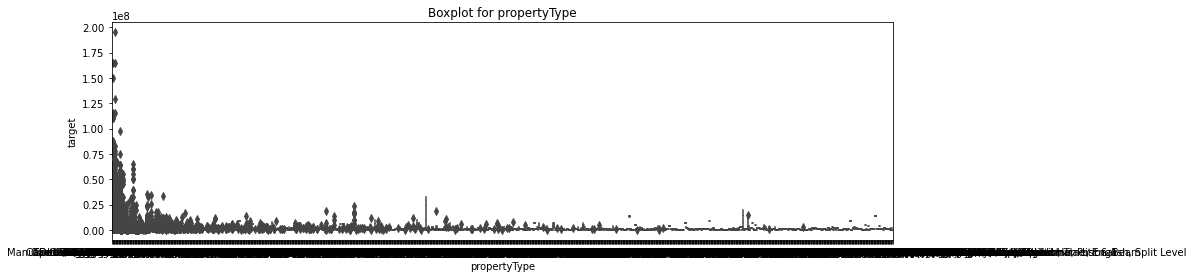

In [34]:
get_boxplot('propertyType')

In [35]:
data.propertyType.value_counts()

single-family home                                             91376
Single Family                                                  61888
Single Family Home                                             31725
condo                                                          25878
lot/land                                                       20532
                                                               ...  
1 Story, Contemporary, Other (See Remarks)                         1
Custom, Elevated, Other                                            1
Contemporary, Farmhouse                                            1
2 Stories, Traditional, Mediterranean, Texas Hill Country          1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: propertyType, Length: 1279, dtype: int64

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335447 non-null  object
 1   private_pool  4151 non-null    object
 2   propertyType  340150 non-null  object
 3   street        374702 non-null  object
 4   baths         269328 non-null  object
 5   homeFacts     374704 non-null  object
 6   fireplace     102522 non-null  object
 7   city          374670 non-null  object
 8   schools       374704 non-null  object
 9   sqft          334582 non-null  object
 10  zipcode       374704 non-null  object
 11  beds          283748 non-null  object
 12  state         374704 non-null  object
 13  stories       224910 non-null  object
 14  mls_id        24937 non-null   object
 15  PrivatePool   40121 non-null   object
 16  MlsId         310226 non-null  object
 17  target        374704 non-null  int64 
dtypes: int64(1), object(17)
